
## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Registration of Images in a Stack 


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes







## First we import the usual libraries
Please visit the  section for [pyTEMlib](Ch1-Prerequesites.ipynb#TEM_Library) of the [Prerequesites](Ch1-Prerequesites.ipynb) section for information of necessary packages.

You'll need at least pyTEMlib version 0.7.2019.10

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# Import libraries from the book

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.image_tools as it


# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-Image_Registration'
__notebook_version__ = '2019_10_16'


Populating the interactive namespace from numpy and matplotlib
windows
pyTEM version:  0.7.2019.9


## Load an image stack :

Please, load an image stack. <br>

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

Note that the **open file dialog** might not apear in the foreground!

<IPython.core.display.Javascript object>


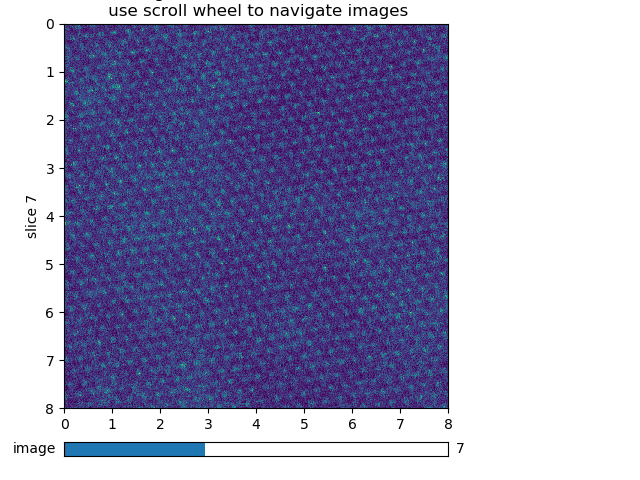

Measurement_000 Channel_000 :  C-8nm-4-3D Stack


In [3]:
######### ###
# Load file #
#############

# First close file if one is open
try:
    h5_file.close()
except: 
    pass

# open file

h5_file = ft.h5_open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

if current_channel['data_type'][()] != 'image_stack':
    print(f"Please load an image stack for this notebook, this is an {current_channel['data_type'][()]}")
    
#plt.figure()
view = ft.h5_plot(current_channel)

          
for base in h5_file:
    if 'Measurement' in base:
        for key in h5_file['Measurement_000']:
            print(base, key,': ', h5_file[base][key]['title'][()])
            if 'Channel' in key:
                for key2 in h5_file[base][key]:
                    if 'Log' in key2:
                        print('\t',key2,': ',h5_file[base][key][key2]['analysis'][()] )
    elif 'Structure' in base:
        print(base,': ', h5_file[base]['title'][()])
    else:
        print(base)      
          
        

In [4]:
print(dict(current_channel.attrs)['time_last_modified'])


1560179552.0


## Input stack data
We put all the input data into a dictionary named tags

In [4]:
 ## spatial data
tags = {}
tags['sizeX'] = current_channel['spatial_size_x'][()]
tags['sizeY'] = current_channel['spatial_size_y'][()]
tags['scaleX'] = current_channel['spatial_scale_x'][()]
tags['scaleY'] = current_channel['spatial_scale_y'][()]
tags['extent'] = (0,tags['sizeX']*tags['scaleX'],tags['sizeY']*tags['scaleY'],0)
if 'image_stack' in current_channel:
    tags['image_stack'] = current_channel['image_stack'][()] 
     

# Registration

If this is an image stack we need to register and add the images. 

If this is not an image stack, we just take whatever image you opened.


In [9]:
[xpmin,xpmax,ypmin,ypmax] = map(int, image_boundaries)

print(xpmin,xpmax,ypmin,ypmax)

9 501 9 501


Image stack
Stack contains  20  images, each with 512  pixels in the x-direction and  512  pixels in the y-direction
Image number 0  xshift =  -3.084  y-shift = -13.297
Image number 1  xshift =  -4.048  y-shift = -11.416
Image number 2  xshift =  -4.645  y-shift = -9.538
Image number 3  xshift =  -5.411  y-shift = -7.38
Image number 4  xshift =  8.782  y-shift = -11.719
Image number 5  xshift =  -9.056  y-shift = -3.099
Image number 6  xshift =  5.748  y-shift = -7.7
Image number 7  xshift =  4.748  y-shift = -5.751
Image number 8  xshift =  3.819  y-shift = -3.751
Image number 9  xshift =  1.748  y-shift = -1.751
Image number 10  xshift =  -0.001  y-shift = -0.001
Image number 11  xshift =  -0.751  y-shift = 1.671
Image number 12  xshift =  -1.751  y-shift = 2.748
Image number 13  xshift =  -2.454  y-shift = 4.748
Image number 14  xshift =  -3.37  y-shift = 6.748
Image number 15  xshift =  -2.276  y-shift = -9.453
Image number 16  xshift =  -4.1370000000000005  y-shift = -6.751
Image 

<IPython.core.display.Javascript object>


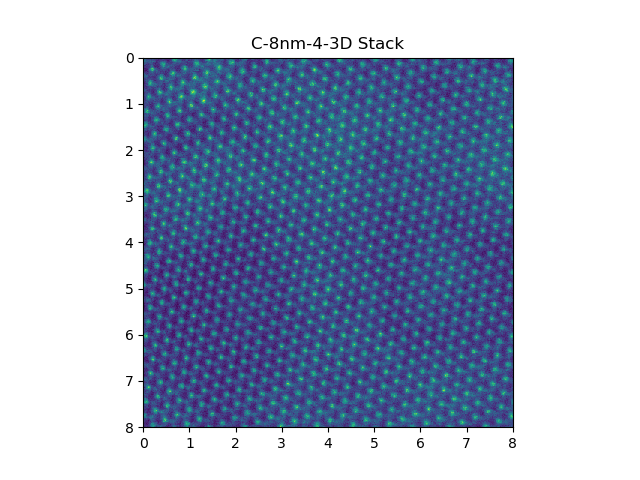

In [10]:
if 'image_stack' in tags:
    print('Image stack')
    out_tags = {}   
    data_cube = tags['image_stack']
    nopix = data_cube.shape[0]
    nopiy = data_cube.shape[1]
    nimages = data_cube.shape[2]

    print('Stack contains ',nimages,' images, each with',nopix,' pixels in the x-direction and ', nopiy,' pixels in the y-direction')

    stack = np.transpose(data_cube, axes=(1,0,2) )
    
    RigReg ,drift = it.dftRigReg(stack)
    image_boundaries = it.CropImage(drift[:], stack.shape, verbose = False)

    [xpmin,xpmax,ypmin,ypmax] = map(int, image_boundaries)

    print()        
    print ('Cropped area ranges',xpmin,':',xpmax, ' in the x-direction')         
    print ('Cropped area ranges',ypmin,':',ypmax, ' in the y-direction')   
    ixrange = xpmax-xpmin + 1 
    iyrange = ypmax-ypmin + 1
    print('Which results in a cropped image',ixrange,' pixels in the x direction and',iyrange, 'pixel in the y-direction' )
    RigReg_crop = RigReg[int(ypmin):ypmax+1, xpmin:xpmax+1,:] # Note we only use the images with continuous drift

    RigReg_image = np.sum(RigReg_crop, axis=2)
    size = np.min(RigReg_image.shape)
    im = RigReg_image[0:size,0:size]
    
    out_tags['image_stack']=RigReg_crop
    out_tags['Rigid_registration_drift']=drift
    out_tags['data']=im
    
else:
    
    data = current_channel['Raw_Data'][()]
    im = np.reshape(data, [tags['sizeX'], tags['sizeY']])
    
plt.figure()
plt.title(current_channel['title'][()] )
plt.imshow(im,extent = tags['extent'], origin = 'upper');

## Log Rigid Registration

<IPython.core.display.Javascript object>


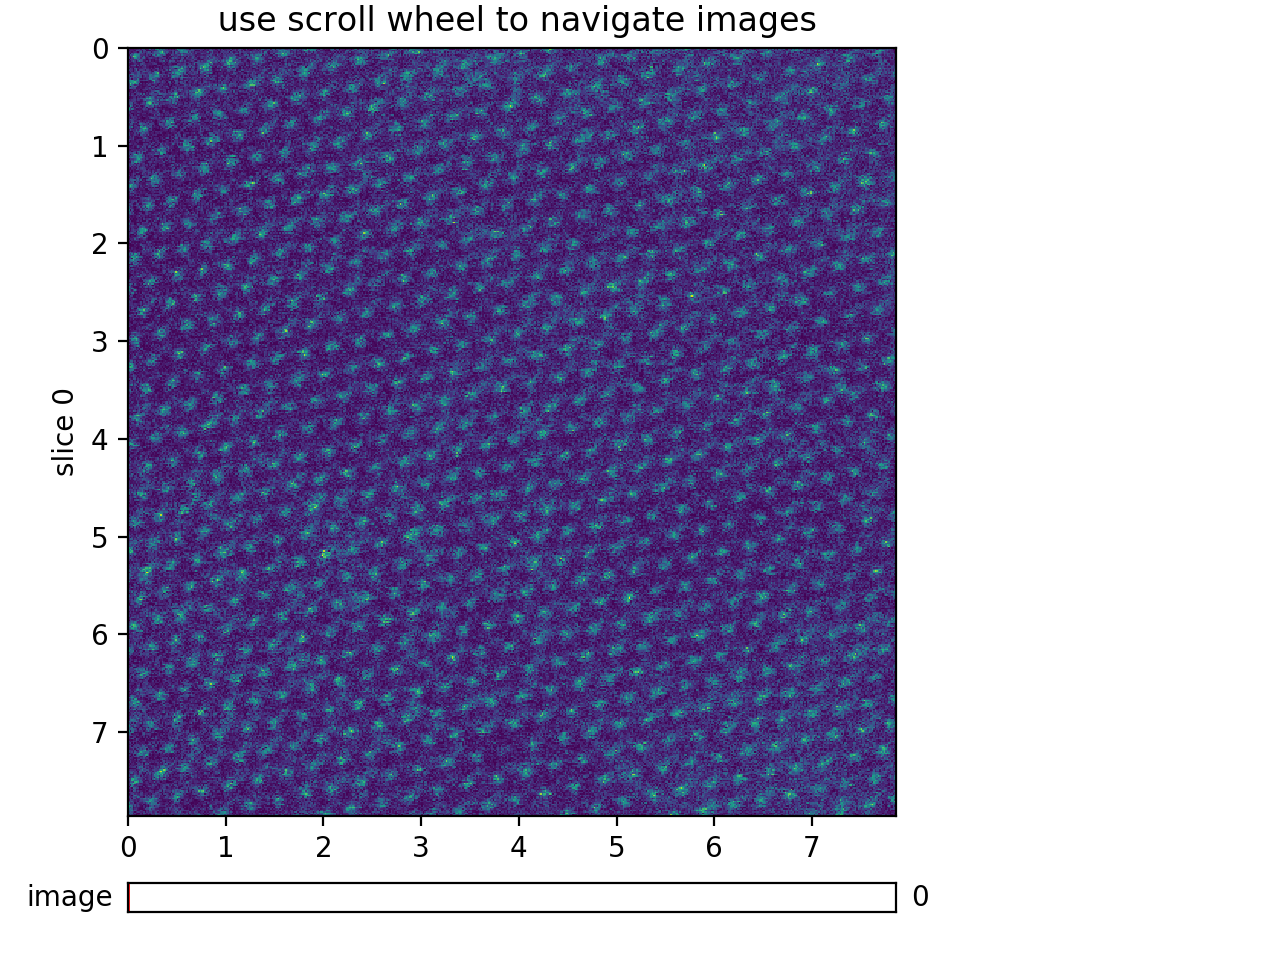

In [8]:

out_tags['analysis'] = 'Rigid Registration'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['data'] = im
out_tags['data_type'] = 'image_stack'   
out_tags['image_stack']=RigReg_crop
out_tags['Rigid_registration_drift']=drift
out_tags['data']=im
    
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = im.shape[0]
out_tags['spatial_size_y'] = im.shape[1]
out_tags['spatial_units'] = 'nm'


FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'rigid_registration'
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group,  out_tags)


#ft.h5_tree(h5_file)


plt.figure()
view = ft.h5_slice_viewer(log_group)


# Plot Sample Drift

<IPython.core.display.Javascript object>


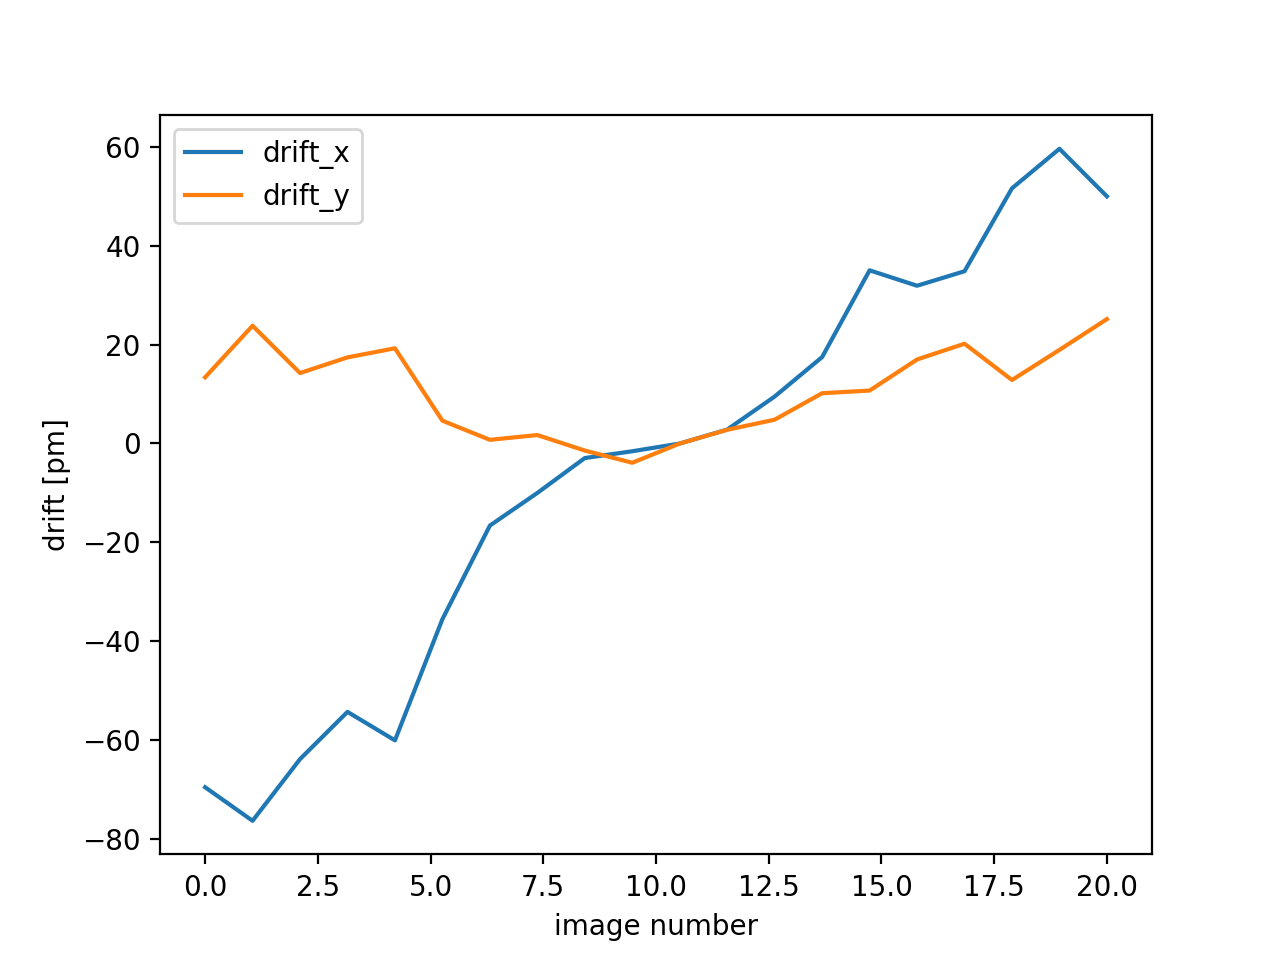

In [9]:
drift_data = current_channel['Log_000']['Rigid_registration_drift'][()]* current_channel['spatial_scale_x'][()]*1000

plt.figure()
plt.plot(np.linspace(0,drift_data.shape[0],drift_data.shape[0]), drift_data[:,0], label = 'drift_x')
plt.plot(np.linspace(0,drift_data.shape[0],drift_data.shape[0]), drift_data[:,1], label = 'drift_y')
plt.xlabel('image number')
plt.ylabel('drift [pm]')
plt.legend();

## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

[==================================================] 100%:-)
You have succesfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


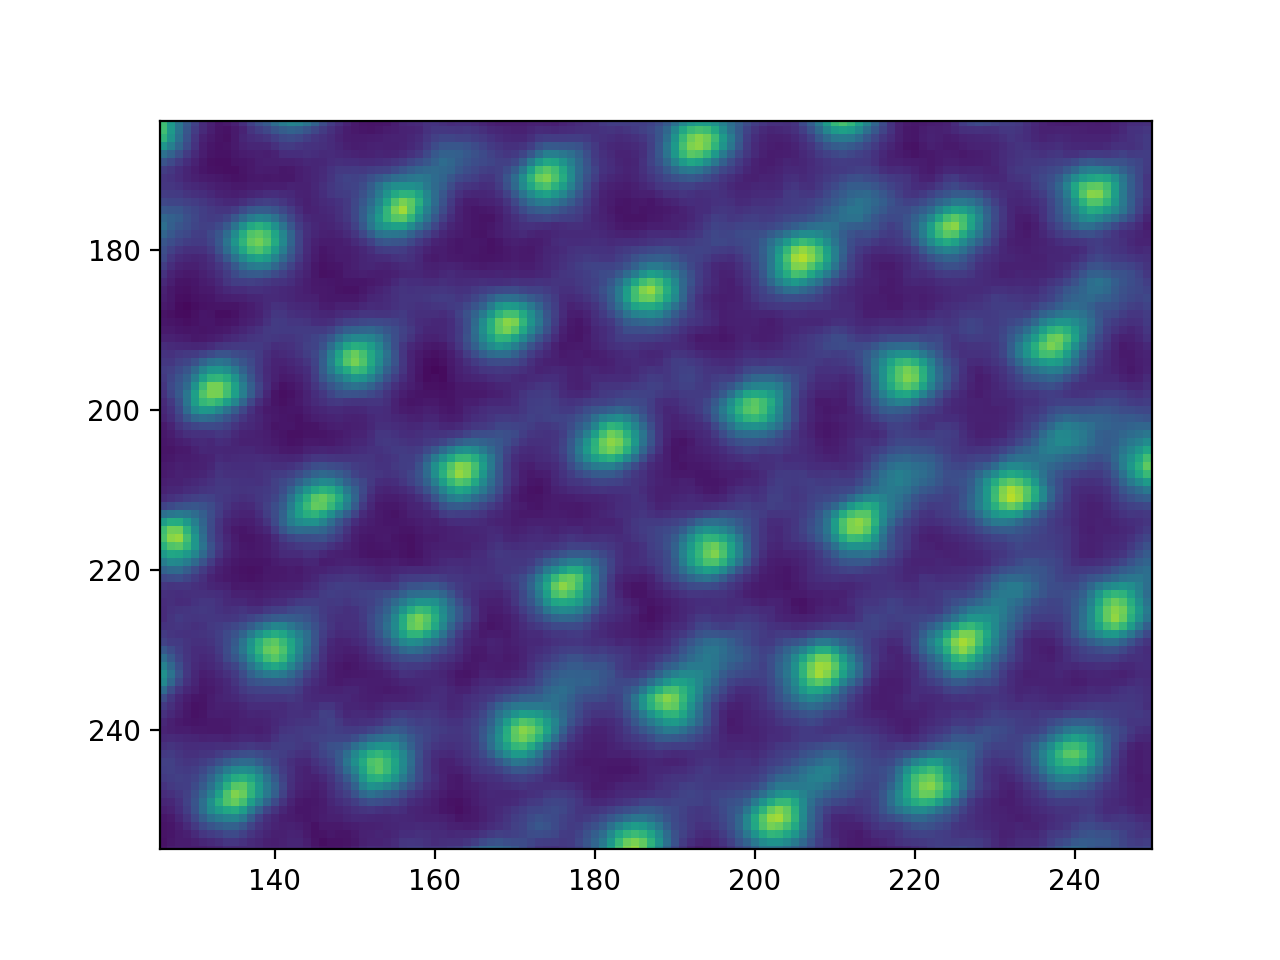

In [10]:
image_stack = current_channel['Log_000']['image_stack'][()]

non_rigid_registered = it.DemonReg(image_stack)

DemReg_image = np.sum(non_rigid_registered, axis=2)

plt.figure()
plt.imshow(DemReg_image);

## Log Non-Rigid Registration

please note that you can always delete a **Log** group with:<br>
*del current_channel['Log_001']*

Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration


<IPython.core.display.Javascript object>


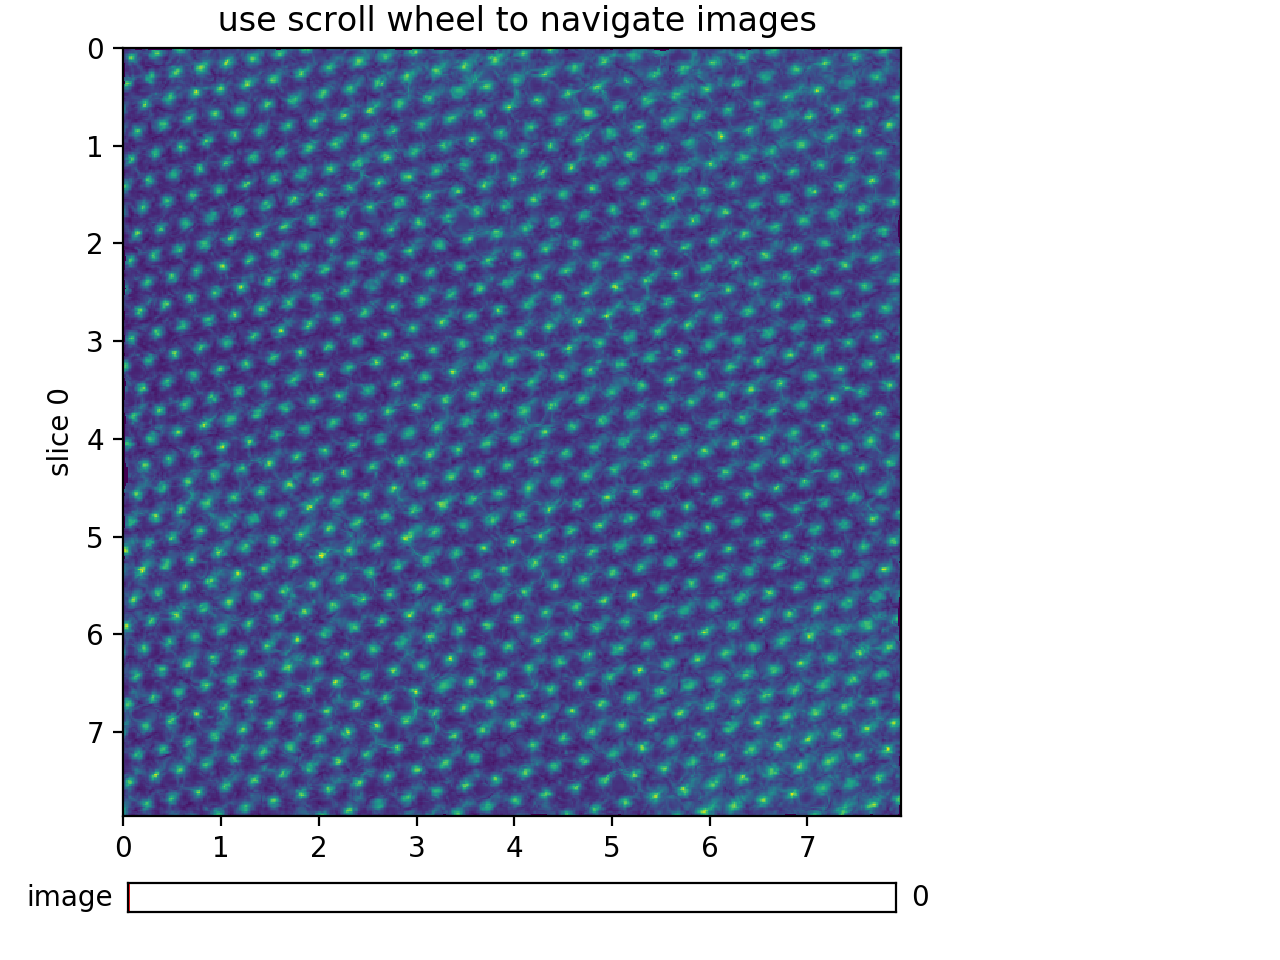

In [11]:
out_tags={}

out_tags['analysis']= 'Non-Rigid Registration'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['data'] = np.sum(non_rigid_registered, axis=2)
out_tags['image_stack'] = non_rigid_registered
out_tags['data_type'] = 'image_stack'    
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = DemReg_image.shape[0]
out_tags['spatial_size_y'] = DemReg_image.shape[1]
out_tags['spatial_units'] = 'nm'

FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'non-rigid_registration'
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group, out_tags)

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

plt.figure()
view = ft.h5_slice_viewer(log_group)


# Close File



In [12]:
h5_file.close()

You can open this file now in the [Find atom positions](CH3-Find_Atoms.ipynb) notebook.  